In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

from datetime import datetime

import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Download dataset from NYC Open Data portal

#! curl https://data.cityofnewyork.us/api/views/7bgx-5tdq/rows.csv?accessType=DOWNLOAD > nyc311.csv

In [3]:
nyc311 = pd.read_csv('nyc311.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (8,17,18,31,32,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#nyc311.head()

In [5]:
nyc311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [6]:
# Drop unneccesary columns

nyc311.drop(['Closed Date','Agency','Location Type','Cross Street 1', 'Cross Street 2',
              'Intersection Street 1', 'Intersection Street 2','Address Type','Landmark', 'Facility Type', 'Status', 
             'Due Date','Resolution Description','Resolution Action Updated Date','BBL','X Coordinate (State Plane)',
             'Y Coordinate (State Plane)','Open Data Channel Type',
             'Park Facility Name','Park Borough','Vehicle Type','Taxi Company Borough','Taxi Pick Up Location',
             'Bridge Highway Name','Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
            'Location'], axis=1, inplace=True)

In [7]:
nyc311.shape

(1696078, 13)

In [8]:
nyc311.head()

,Unique Key,Created Date,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,City,Community Board,Borough,Latitude,Longitude
0,42605380,05/07/2019 11:45:00 PM,Department of Environmental Protection,Sewer,Manhole Overflow (Use Comments) (SA1),11212,316 LIVONIA AVENUE,LIVONIA AVENUE,BROOKLYN,16 BROOKLYN,BROOKLYN,40.662967,-73.906075
1,42868652,06/03/2019 10:52:26 PM,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,11219,1342 67 STREET,67 STREET,BROOKLYN,10 BROOKLYN,BROOKLYN,40.624216,-74.001747
2,45734992,03/02/2020 08:09:29 PM,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,10454,522 EAST 138 STREET,EAST 138 STREET,BRONX,01 BRONX,BRONX,40.807298,-73.918645
3,45764246,03/05/2020 08:39:00 PM,Department of Sanitation,Graffiti,Graffiti,11219,6406 11 AVENUE,11 AVENUE,BROOKLYN,10 BROOKLYN,BROOKLYN,40.629137,-74.005429
4,45821513,03/07/2020 11:33:29 AM,Department of Parks and Recreation,Damaged Tree,Tree Alive - in Poor Condition,10302,126 VEDDER AVENUE,VEDDER AVENUE,STATEN ISLAND,01 STATEN ISLAND,STATEN ISLAND,40.620692,-74.146205


In [9]:
nyc311.head()

,Unique Key,Created Date,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,City,Community Board,Borough,Latitude,Longitude
0,42605380,05/07/2019 11:45:00 PM,Department of Environmental Protection,Sewer,Manhole Overflow (Use Comments) (SA1),11212,316 LIVONIA AVENUE,LIVONIA AVENUE,BROOKLYN,16 BROOKLYN,BROOKLYN,40.662967,-73.906075
1,42868652,06/03/2019 10:52:26 PM,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,11219,1342 67 STREET,67 STREET,BROOKLYN,10 BROOKLYN,BROOKLYN,40.624216,-74.001747
2,45734992,03/02/2020 08:09:29 PM,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,10454,522 EAST 138 STREET,EAST 138 STREET,BRONX,01 BRONX,BRONX,40.807298,-73.918645
3,45764246,03/05/2020 08:39:00 PM,Department of Sanitation,Graffiti,Graffiti,11219,6406 11 AVENUE,11 AVENUE,BROOKLYN,10 BROOKLYN,BROOKLYN,40.629137,-74.005429
4,45821513,03/07/2020 11:33:29 AM,Department of Parks and Recreation,Damaged Tree,Tree Alive - in Poor Condition,10302,126 VEDDER AVENUE,VEDDER AVENUE,STATEN ISLAND,01 STATEN ISLAND,STATEN ISLAND,40.620692,-74.146205


In [10]:
# Convert data to date-time form

nyc311['Created Date'] = pd.to_datetime(nyc311['Created Date'], format='%Y%m%d', infer_datetime_format=True)

In [11]:
nyc311.rename(str.lower, axis='columns', inplace=True)

In [12]:
nyc311.rename(columns = {'incident zip':'zipcode'}, inplace=True)

In [13]:
nyc311.shape

(1696078, 13)

In [14]:
nyc311.head()

,unique key,created date,agency name,complaint type,descriptor,zipcode,incident address,street name,city,community board,borough,latitude,longitude
0,42605380,2019-05-07 23:45:00,Department of Environmental Protection,Sewer,Manhole Overflow (Use Comments) (SA1),11212,316 LIVONIA AVENUE,LIVONIA AVENUE,BROOKLYN,16 BROOKLYN,BROOKLYN,40.662967,-73.906075
1,42868652,2019-06-03 22:52:26,Department of Buildings,Building/Use,Illegal Conversion Of Residential Building/Space,11219,1342 67 STREET,67 STREET,BROOKLYN,10 BROOKLYN,BROOKLYN,40.624216,-74.001747
2,45734992,2020-03-02 20:09:29,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,10454,522 EAST 138 STREET,EAST 138 STREET,BRONX,01 BRONX,BRONX,40.807298,-73.918645
3,45764246,2020-03-05 20:39:00,Department of Sanitation,Graffiti,Graffiti,11219,6406 11 AVENUE,11 AVENUE,BROOKLYN,10 BROOKLYN,BROOKLYN,40.629137,-74.005429
4,45821513,2020-03-07 11:33:29,Department of Parks and Recreation,Damaged Tree,Tree Alive - in Poor Condition,10302,126 VEDDER AVENUE,VEDDER AVENUE,STATEN ISLAND,01 STATEN ISLAND,STATEN ISLAND,40.620692,-74.146205


In [15]:
nyc311['day_of_week'] = nyc311['created date'].dt.dayofweek

In [16]:
# Segment by date for 2019 & 2020 dataframes

nyc311_2019 = nyc311[nyc311['created date'] < '2019-07-01']
nyc311_2020 = nyc311[nyc311['created date'] >= '2020-01-01']

print(nyc311_2019.shape)
print(nyc311_2020.shape)

(931850, 14)
(764228, 14)


In [17]:
# Segment by zip for Brooklyn

brooklynzips = [11212, 11213, 11216, 11233, 11238,11209, 11214, 11228,
               11204, 11218, 11219, 11230, 11234, 11236, 11239,
               11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231,
               11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222,
               11220, 11232, 11206, 11221, 11237]

brooklyn2019 = nyc311_2019[(nyc311_2019['borough'] == 'BROOKLYN') & (nyc311_2019['zipcode'].isin(brooklynzips))]
brooklyn2020 = nyc311_2020[(nyc311_2020['borough'] == 'BROOKLYN') & (nyc311_2020['zipcode'].isin(brooklynzips))]

print(brooklyn2019.shape)
print(brooklyn2020.shape)

(231677, 14)
(207636, 14)


In [18]:
brownsville2019 = nyc311_2019[nyc311_2019['zipcode'] == 11212]
brownsville2020 = nyc311_2020[nyc311_2020['zipcode'] == 11212]

print(brownsville2019.shape)
print(brownsville2020.shape)

(6967, 14)
(6442, 14)


Through our cosine score analysis, I will use zip code **11203 (East Flatbush)** for similarity, and zip code **11215 (Park Slope)** to show dissimilarity trends.

In [19]:
eastflat2019 = nyc311_2019[nyc311_2019['zipcode'] == 11203]
eastflat2020 = nyc311_2020[nyc311_2020['zipcode'] == 11203]

parkslope2019 = nyc311_2019[nyc311_2019['zipcode'] == 11215]
parkslope2020 = nyc311_2020[nyc311_2020['zipcode'] == 11215]

In [20]:
print(eastflat2019.shape)
print(eastflat2020.shape)

print(parkslope2019.shape)
print(parkslope2020.shape)

(7231, 14)
(5694, 14)
(7523, 14)
(4577, 14)


## Brownsville 311 Complaints by Type

In [21]:
bv2019 = brownsville2019.groupby('complaint type', as_index=False).count()
bv2020 = brownsville2020.groupby('complaint type', as_index=False).count()

In [22]:
# Filter only for types with over 100 complaints

bv2019 = bv2019[bv2019['unique key'] > 100]
bv2020 = bv2020[bv2020['unique key'] > 100]

bv2019.sort_values(by='unique key', inplace=True)
bv2020.sort_values(by='unique key', inplace=True)

In [23]:
bv2019 = bv2019[['complaint type','unique key']]
bv2020 = bv2020[['complaint type','unique key']]

In [24]:
# Calculate percent of total calls for each call type

bv2019['percent_tot'] = (bv2019['unique key'] / bv2019['unique key'].sum()) * 100
bv2019['year'] = 2019

In [25]:
bv2020['percent_tot'] = (bv2020['unique key'] / bv2020['unique key'].sum()) * 100
bv2020['year'] = 2020

In [26]:
bv311 = bv2019.append(bv2020)

In [27]:
bv311.head()

,complaint type,unique key,percent_tot,year
99,Sewer,105,1.937984,2019
117,Traffic Signal Condition,112,2.067183,2019
120,Unsanitary Condition,124,2.288667,2019
48,GENERAL,126,2.325581,2019
60,Illegal Parking,126,2.325581,2019


In [28]:
bv311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)

In [29]:
bv311['percent_tot'] = bv311['percent_tot'].astype(float)

In [30]:
bv311['percent_tot'].dtype

dtype('float64')

In [31]:
bv311 = bv311[bv311['percent_tot'] >= 5]

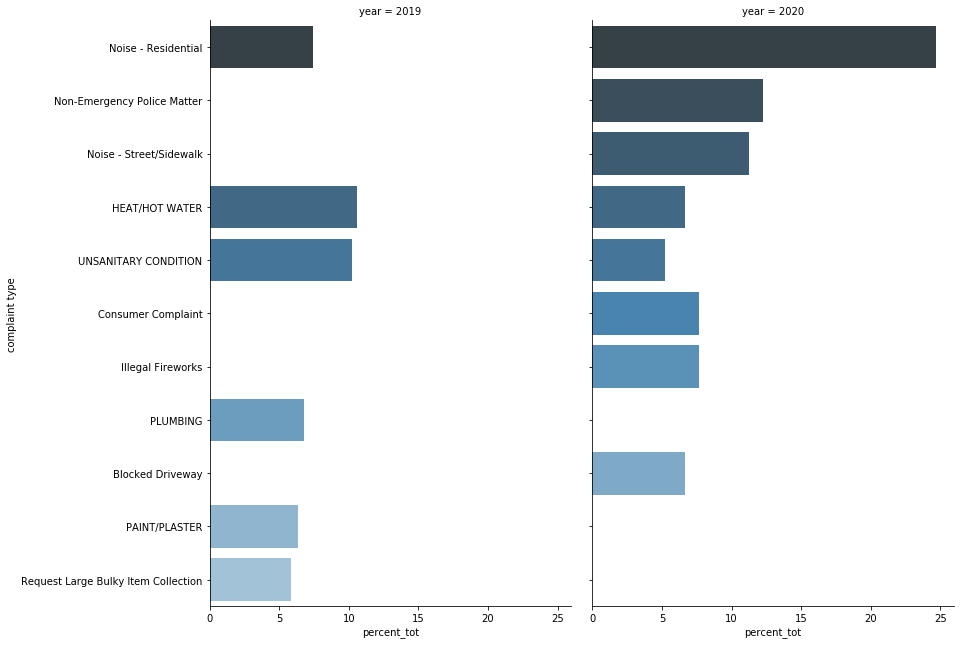

In [32]:
ax = sns.catplot(x="percent_tot", y="complaint type", col='year',data=bv311, kind='bar',
                palette="Blues_d").fig.set_size_inches(15,10)

## East Flatbush and Redhook 311 Complaints by Type

In [33]:
ef2019 = eastflat2019.groupby('complaint type', as_index=False).count()
ef2020 = eastflat2020.groupby('complaint type', as_index=False).count()

ps2019 = parkslope2019.groupby('complaint type', as_index=False).count()
ps2020 = parkslope2020.groupby('complaint type', as_index=False).count()

In [34]:
ef2019 = ef2019[ef2019['unique key'] > 100]
ef2020 = ef2020[ef2020['unique key'] > 100]
ps2019 = ps2019[ps2019['unique key'] > 100]
ps2020 = ps2020[ps2020['unique key'] > 100]


ef2019.sort_values(by='unique key', inplace=True)
ef2020.sort_values(by='unique key', inplace=True)
ps2019.sort_values(by='unique key', inplace=True)
ps2020.sort_values(by='unique key', inplace=True)

In [35]:
ef2019 = ef2019[['complaint type','unique key']]
ef2020 = ef2020[['complaint type','unique key']]

ps2019 = ps2019[['complaint type','unique key']]
ps2020 = ps2020[['complaint type','unique key']]

In [36]:
ef2019['percent_tot'] = (ef2019['unique key'] / ef2019['unique key'].sum()) * 100
ef2019['year'] = 2019

ps2019['percent_tot'] = (ps2019['unique key'] / ps2019['unique key'].sum()) * 100
ps2019['year'] = 2019

In [37]:
ef2020['percent_tot'] = (ef2020['unique key'] / ef2020['unique key'].sum()) * 100
ef2020['year'] = 2020

ps2020['percent_tot'] = (ps2020['unique key'] / ps2020['unique key'].sum()) * 100
ps2020['year'] = 2020

In [38]:
ef311 = ef2019.append(ef2020)
ps311 = ps2019.append(ps2020)

In [39]:
ef311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)
ps311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)

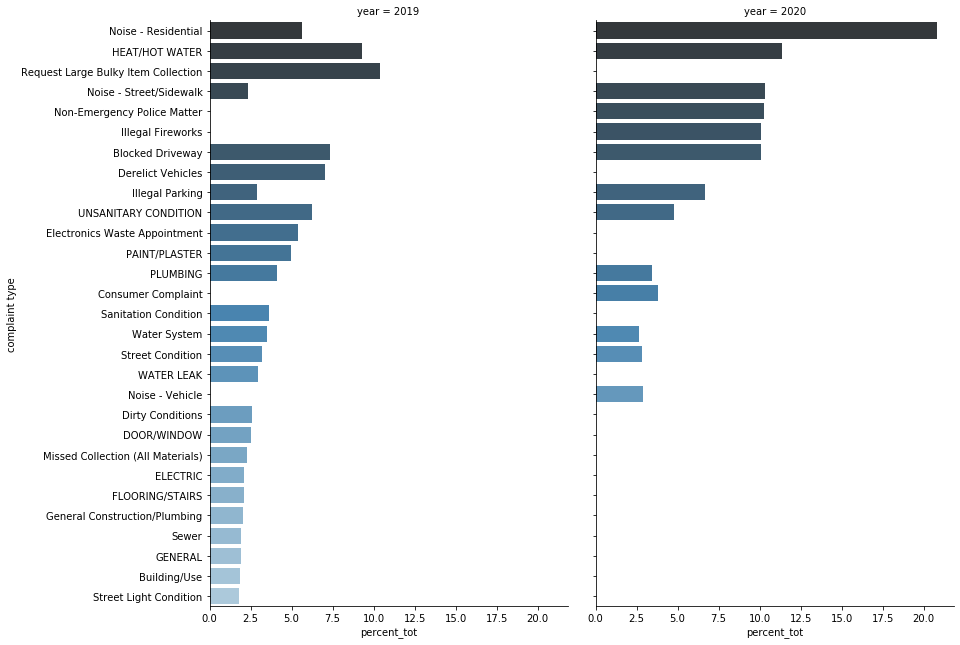

In [40]:
ax = sns.catplot(x="percent_tot", y="complaint type", col='year',data=ef311, kind='bar',
                palette="Blues_d").fig.set_size_inches(15,10)

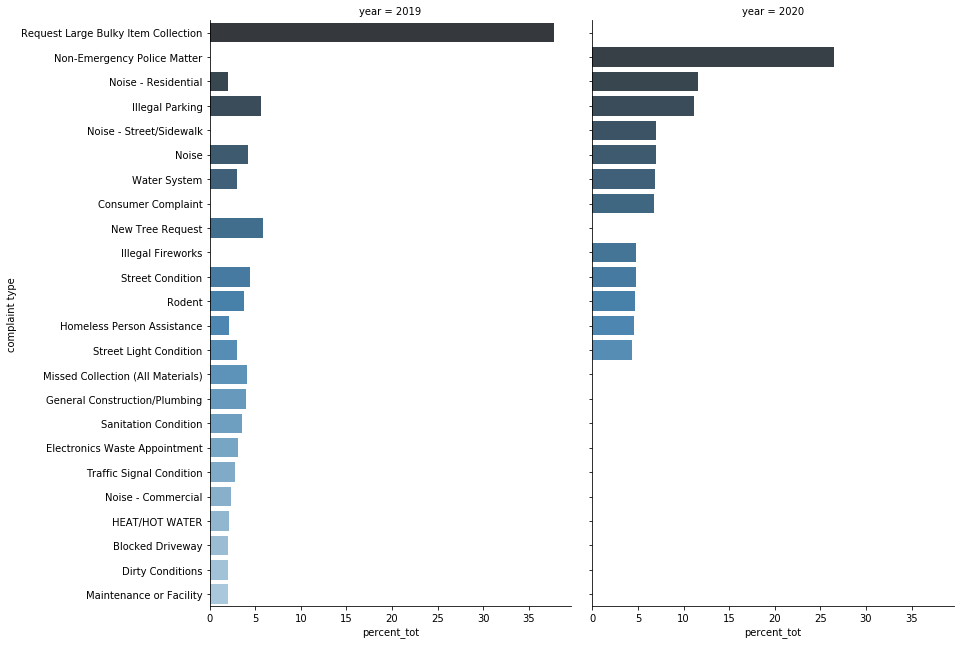

In [41]:
ax = sns.catplot(x="percent_tot", y="complaint type", col='year',data=ps311, kind='bar',
                palette="Blues_d").fig.set_size_inches(15,10)

## Brownsville Complaints by Department

In [42]:
nycdp2019 = brownsville2019.groupby('agency name', as_index=False).count()
nycdp2020 = brownsville2020.groupby('agency name', as_index=False).count()

In [43]:
nycdp2019.sort_values(by='unique key', inplace=True)
nycdp2020.sort_values(by='unique key', inplace=True)

In [44]:
nycdp2019 = nycdp2019[['agency name','unique key']]
nycdp2020 = nycdp2020[['agency name','unique key']]

In [45]:
nycdp2019['percent_tot'] = (nycdp2019['unique key'] / nycdp2019['unique key'].sum()) * 100
nycdp2019['year'] = 2019

In [46]:
nycdp2020['percent_tot'] = (nycdp2020['unique key'] / nycdp2020['unique key'].sum()) * 100
nycdp2020['year'] = 2020

In [47]:
nycdp311 = nycdp2019.append(nycdp2020)

In [48]:
# Only show departments with at least 5% of total calls, for cleaner visual

nycdp311 = nycdp311[nycdp311['percent_tot'] > 5]

In [49]:
nycdp311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)

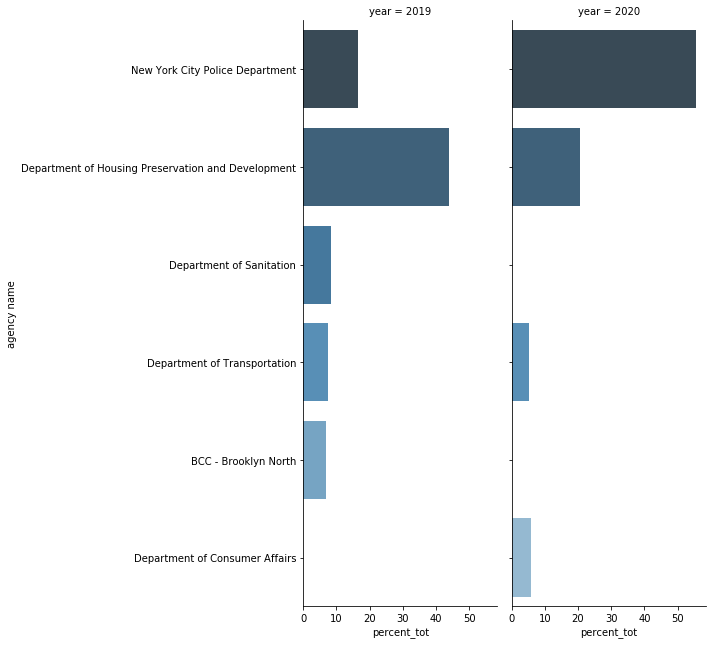

In [50]:
ax = sns.catplot(x="percent_tot", y="agency name", col='year',data=nycdp311, kind='bar',
                palette="Blues_d").fig.set_size_inches(10,10)

## East Flatbush & Red Hook Complaints by Department

In [51]:
nycef2019 = eastflat2019.groupby('agency name', as_index=False).count()
nycef2020 = eastflat2020.groupby('agency name', as_index=False).count()

nycps2019 = parkslope2019.groupby('agency name', as_index=False).count()
nycps2020 = parkslope2020.groupby('agency name', as_index=False).count()

In [52]:
nycef2019.sort_values(by='unique key', inplace=True)
nycef2020.sort_values(by='unique key', inplace=True)

nycps2019.sort_values(by='unique key', inplace=True)
nycps2020.sort_values(by='unique key', inplace=True)

In [53]:
nycef2019 = nycef2019[['agency name','unique key']]
nycef2020 = nycef2020[['agency name','unique key']]

nycps2019 = nycps2019[['agency name','unique key']]
nycps2020 = nycps2020[['agency name','unique key']]

In [54]:
nycef2019['percent_tot'] = (nycef2019['unique key'] / nycef2019['unique key'].sum()) * 100
nycef2019['year'] = 2019

nycps2019['percent_tot'] = (nycps2019['unique key'] / nycps2019['unique key'].sum()) * 100
nycps2019['year'] = 2019

In [55]:
nycef2020['percent_tot'] = (nycef2020['unique key'] / nycef2020['unique key'].sum()) * 100
nycef2020['year'] = 2020

nycps2020['percent_tot'] = (nycps2020['unique key'] / nycps2020['unique key'].sum()) * 100
nycps2020['year'] = 2020

In [56]:
nycef311 = nycef2019.append(nycef2020)
nycps311 = nycps2019.append(nycps2020)

In [57]:
nycef311 = nycef311[nycef311['percent_tot'] > 5]
nycps311 = nycps311[nycps311['percent_tot'] > 5]

In [58]:
nycef311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)
nycps311.sort_values(by=['percent_tot','year'], ascending=False, inplace=True)

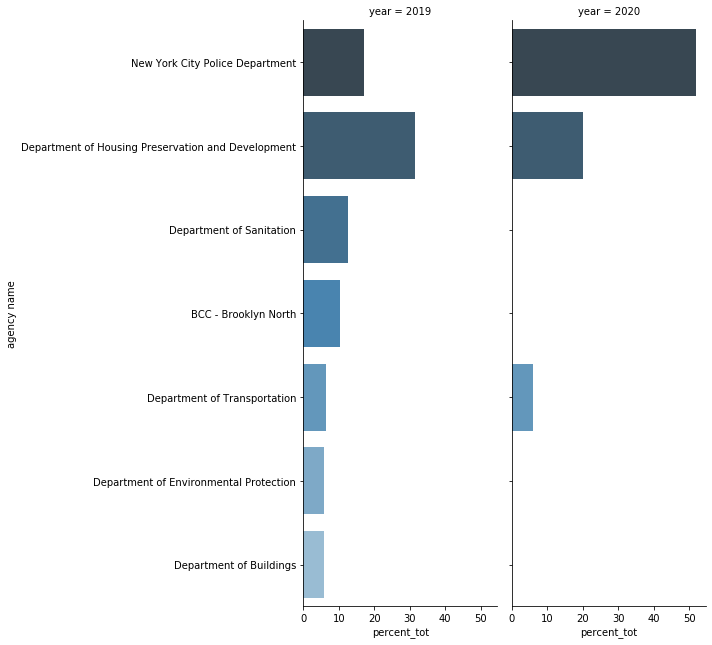

In [59]:
ax = sns.catplot(x="percent_tot", y="agency name", col='year',data=nycef311, kind='bar',
                palette="Blues_d").fig.set_size_inches(10,10)

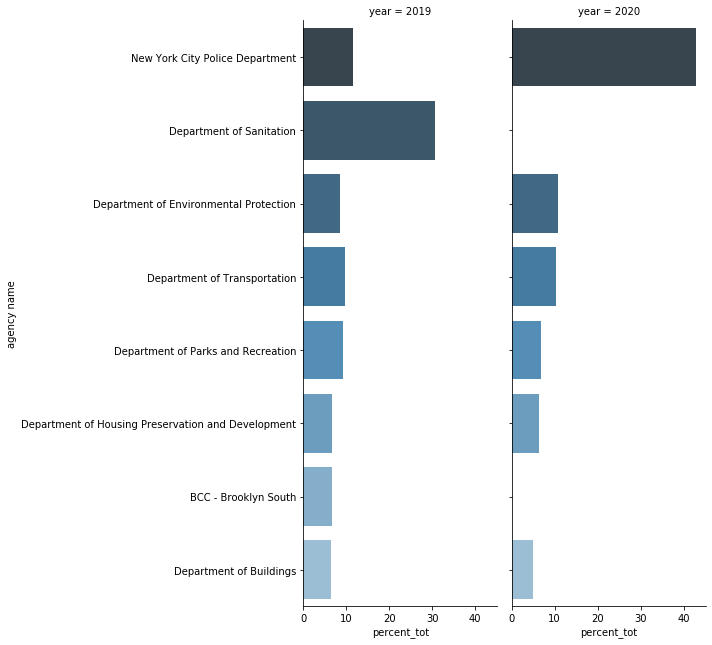

In [60]:
ax = sns.catplot(x="percent_tot", y="agency name", col='year',data=nycps311, kind='bar',
                palette="Blues_d").fig.set_size_inches(10,10)

## Time Series

In [61]:
bv2019ts = brownsville2019.groupby(pd.DatetimeIndex(brownsville2019['created date']).normalize()).count()

In [62]:
bv2019ts['date'] = bv2019ts.index

In [63]:
bv2019ts = bv2019ts[['date','unique key']]

In [64]:
bv2020ts = brownsville2020.groupby(pd.DatetimeIndex(brownsville2020['created date']).normalize()).count()

bv2020ts['date'] = bv2020ts.index

In [65]:
bv2020ts = bv2020ts[['date','unique key']]

In [66]:
bv311ts = bv2019ts.append(bv2020ts)

In [67]:
bv311ts.reset_index(drop=True, inplace=True)

In [68]:
bv311ts['year'] = pd.DatetimeIndex(bv311ts['date']).year

In [69]:
bv311ts.head()

,date,unique key,year
0,2019-03-01,78,2019
1,2019-03-02,42,2019
2,2019-03-03,26,2019
3,2019-03-04,52,2019
4,2019-03-05,96,2019


In [70]:
day_count = []
i = 0

for x in bv311ts['year']:
    if x == 2019:
        day_count.append(i+1)
        i += 1
    elif x == 2020:
        day_count.append(i-120)
        i += 1
    else:
        pass

In [71]:
bv311ts['day'] = day_count

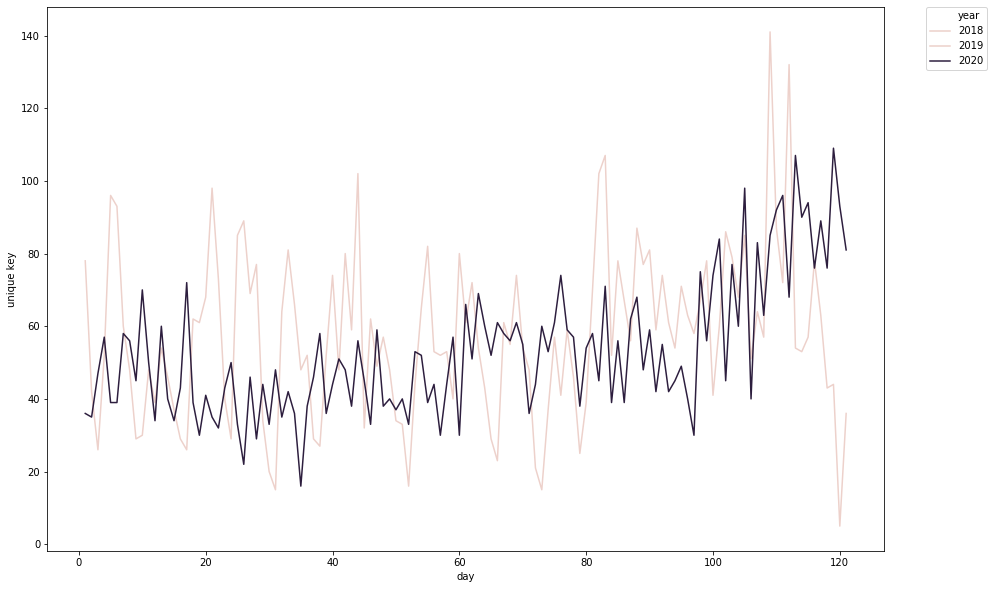

In [72]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(x="day", y="unique key", hue="year", ci=None,
                  data=bv311ts)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## East Flatbush & Red Hook Time Series

In [73]:
ef2019ts = eastflat2019.groupby(pd.DatetimeIndex(eastflat2019['created date']).normalize()).count()
ps2019ts = parkslope2019.groupby(pd.DatetimeIndex(parkslope2019['created date']).normalize()).count()

ef2020ts = eastflat2020.groupby(pd.DatetimeIndex(eastflat2020['created date']).normalize()).count()
ps2020ts = parkslope2020.groupby(pd.DatetimeIndex(parkslope2020['created date']).normalize()).count()

In [74]:
ef2019ts['date'] = ef2019ts.index
ps2019ts['date'] = ps2019ts.index

In [75]:
ef2020ts['date'] = ef2020ts.index
ps2020ts['date'] = ps2020ts.index

In [76]:
ef2019ts = ef2019ts[['date','unique key']]
ps2019ts = ps2019ts[['date','unique key']]

ef2020ts = ef2020ts[['date','unique key']]
ps2020ts = ps2020ts[['date','unique key']]

In [77]:
ef311ts = ef2019ts.append(ef2020ts)
ps311ts = ps2019ts.append(ps2020ts)

In [78]:
ef311ts.reset_index(drop=True, inplace=True)
ps311ts.reset_index(drop=True, inplace=True)

In [79]:
ef311ts['year'] = pd.DatetimeIndex(ef311ts['date']).year
ps311ts['year'] = pd.DatetimeIndex(ps311ts['date']).year

In [80]:
day_count2 = []
i = 0

for x in ef311ts['year']:
    if x == 2019:
        day_count2.append(i+1)
        i += 1
    elif x == 2020:
        day_count2.append(i-120)
        i += 1
    else:
        pass

In [81]:
ef311ts['day'] = day_count2

In [82]:
day_count3 = []
i = 0

for x in ps311ts['year']:
    if x == 2019:
        day_count3.append(i+1)
        i += 1
    elif x == 2020:
        day_count3.append(i-120)
        i += 1
    else:
        pass

In [83]:
ps311ts['day'] = day_count3

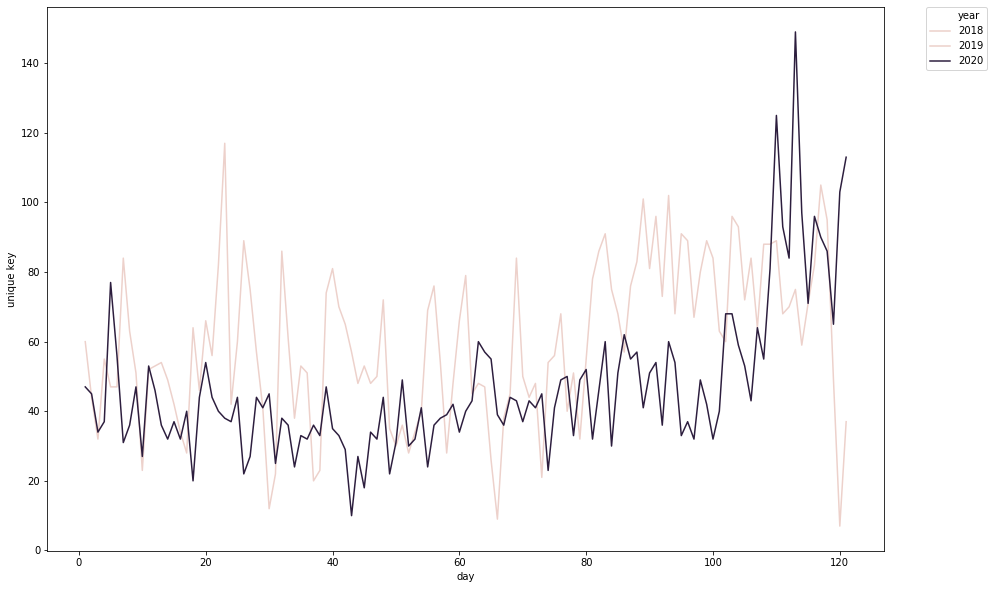

In [84]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(x="day", y="unique key", hue="year", ci=None,
                  data=ef311ts)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

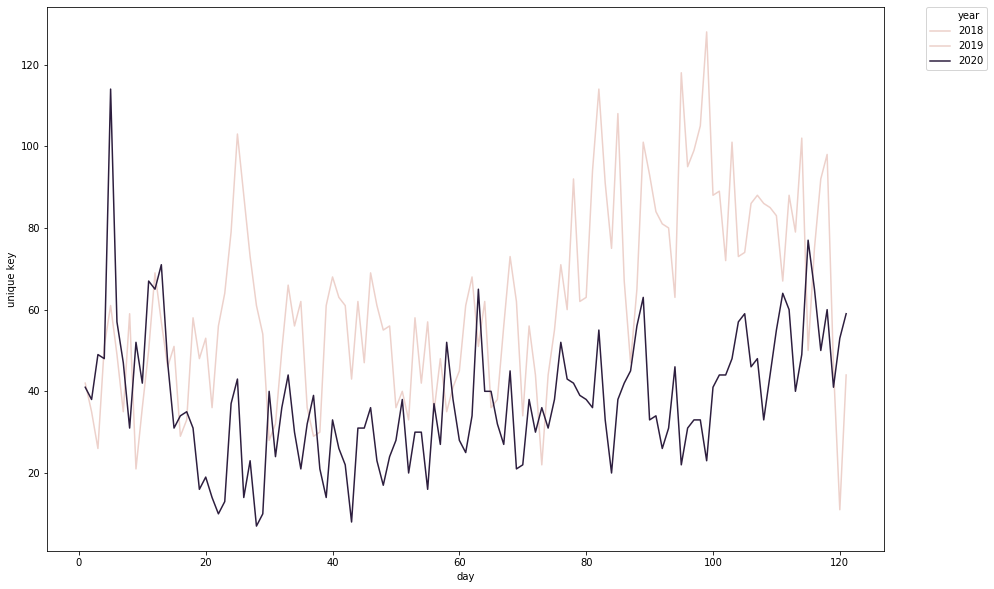

In [85]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(x="day", y="unique key", hue="year", ci=None,
                  data=ps311ts)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Day of Week

In [86]:
nycdow2019 = brownsville2019.groupby('day_of_week', as_index=False).count()
nycdow2020 = brownsville2020.groupby('day_of_week', as_index=False).count()

In [87]:
nycdow2019.sort_values(by='day_of_week', inplace=True)
nycdow2020.sort_values(by='day_of_week', inplace=True)

In [88]:
nycdow2019 = nycdow2019[['day_of_week','unique key']]
nycdow2020 = nycdow2020[['day_of_week','unique key']]

In [89]:
nycdow2019['percent_tot'] = (nycdow2019['unique key'] / nycdow2019['unique key'].sum()) * 100
nycdow2019['year'] = 2019

In [90]:
nycdow2020['percent_tot'] = (nycdow2020['unique key'] / nycdow2020['unique key'].sum()) * 100
nycdow2020['year'] = 2020

In [91]:
nycdow311 = nycdow2019.append(nycdow2020)

In [92]:
nycdow311.sort_values(by=['year','day_of_week'], ascending=True, inplace=True)

In [93]:
days_convert = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

nycdow311.replace({'day_of_week':days_convert}, inplace=True)

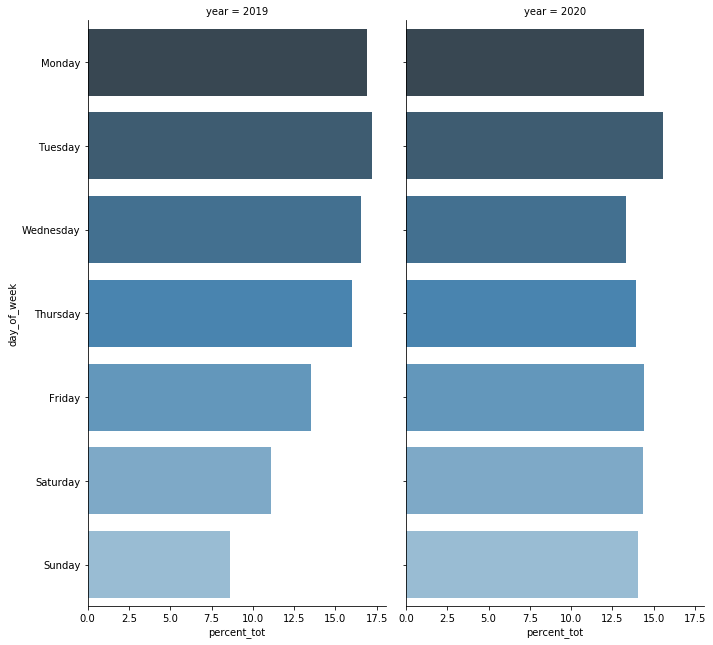

In [94]:
ax = sns.catplot(x="percent_tot", y="day_of_week", col='year',data=nycdow311, kind='bar',
                palette="Blues_d").fig.set_size_inches(10,10)

## Mapping 311 calls

In [95]:
NYCzip = gpd.read_file('NY.shp')

NYCzip.head()

,zipcode,geometry
0,11372.0,"POLYGON Z ((-73.86942 40.74916 0.00000, -73.89..."
1,11004.0,"POLYGON Z ((-73.71068 40.75004 0.00000, -73.70..."
2,11040.0,"POLYGON Z ((-73.70098 40.73890 0.00000, -73.70..."
3,11426.0,"POLYGON Z ((-73.72270 40.75373 0.00000, -73.72..."
4,11365.0,"POLYGON Z ((-73.81089 40.72717 0.00000, -73.81..."


In [96]:
brooklyn_zip = NYCzip[NYCzip['zipcode'].isin(brooklynzips)]

In [97]:
brooklyn2019b = brooklyn2019.groupby('zipcode', as_index=False).count()

In [98]:
brooklyn2019b = brooklyn2019b[['zipcode', 'unique key']]

In [99]:
brooklyn2019b.rename(columns = {'unique key':'count_2019'}, inplace=True)

In [100]:
brooklyn2020b = brooklyn2020.groupby('zipcode', as_index=False).count()

In [101]:
brooklyn2020b = brooklyn2020b[['zipcode', 'unique key']]

In [102]:
brooklyn2020b.rename(columns = {'unique key':'count_2020'}, inplace=True)

In [103]:
brooklyn311both = brooklyn2019b.merge(brooklyn2020b, on='zipcode', left_index=True, right_index=True, how='inner')
brooklyn311both.dropna(inplace = True)

In [104]:
brooklynmap = brooklyn_zip.merge(brooklyn311both, on='zipcode', how='inner')
#brooklynmap.dropna(inplace = True)

In [105]:
brooklynmap.head()

,zipcode,geometry,count_2019,count_2020
0,11221.0,"POLYGON Z ((-73.93822 40.68389 0.00000, -73.94...",9600,9446
1,11216.0,"POLYGON Z ((-73.94564 40.69203 0.00000, -73.94...",7219,6355
2,11233.0,"POLYGON Z ((-73.93822 40.68389 0.00000, -73.91...",7797,6409
3,11213.0,"POLYGON Z ((-73.93740 40.67973 0.00000, -73.92...",6363,6503
4,11212.0,"POLYGON Z ((-73.90294 40.67084 0.00000, -73.90...",6966,6442


In [106]:
brooklynmap['percent_tot_2019'] = (brooklynmap['count_2019'] / brooklynmap['count_2019'].sum()) * 100
brooklynmap['percent_tot_2020'] = (brooklynmap['count_2020'] / brooklynmap['count_2020'].sum()) * 100

In [107]:
brooklynmap['percent_change'] = (brooklynmap['count_2020'] - brooklynmap['count_2019']) / brooklynmap['count_2019'] *100

In [108]:
print(brooklynmap['percent_change'].max())
print(brooklynmap['percent_change'].min())

60.59322033898306
-39.1194466613461


//anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


(-74.05121125029413, -73.8463739352844, 40.56111993449484, 40.74760389552892)

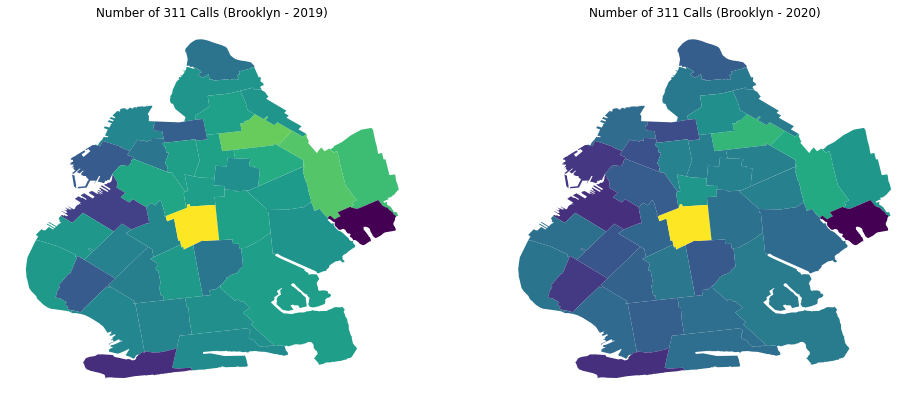

In [109]:
fig = plt.figure(figsize=(25,15))

variable = 'count_2019'
variable2 = 'count_2020'

ax = fig.add_subplot(131)
brooklynmap.plot(column=variable, axes=ax, legend=False)
ax.set_title("Number of 311 Calls (Brooklyn - 2019)")
ax.axis('off')

ax = fig.add_subplot(132)
brooklynmap.plot(column=variable2, axes=ax, legend=False)
ax.set_title("Number of 311 Calls (Brooklyn - 2020)")
ax.axis('off')

#f.savefig('nyc311map.png')

//anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


(-74.05121125029413, -73.8463739352844, 40.56111993449484, 40.74760389552892)

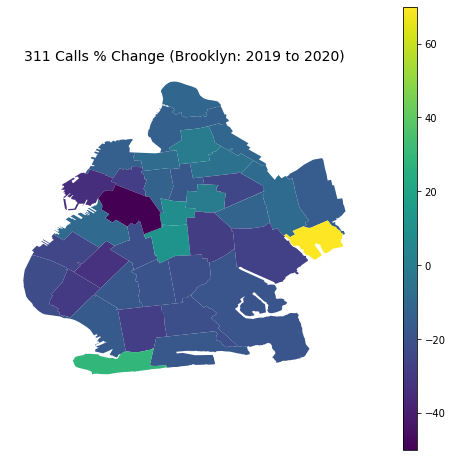

In [110]:
fig = plt.figure(figsize=(25,15))

variable = 'percent_change'
vmin = -50
vmax = 70

ax = fig.add_subplot(131)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))

brooklynmap.plot(column=variable, axes=ax)
fig.colorbar(sm, fraction=0.036, pad=0.1, aspect = 30)
ax.set_title("311 Calls % Change (Brooklyn: 2019 to 2020)", fontsize=14)
ax.axis('off')

## K-means Clustering (by Zip Code)

In [111]:
brooklynCluster = brooklynmap[['count_2019','count_2020']].copy()

In [112]:
brooklynCluster = brooklynCluster - np.mean(brooklynCluster, axis = 0)
brooklynCluster = brooklynCluster / np.std(brooklynCluster, axis = 0)

In [113]:
# Calculate silhouette scores for range of clusters

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters: #try different numbers of clusters
    km = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = km.fit_predict(brooklynCluster)
    
    #report average Silhouette score
    silhouette_avg = silhouette_score(brooklynCluster, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is: {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is: 0.47687805278737716
For n_clusters = 3, the average silhouette_score is: 0.5872324520556081
For n_clusters = 4, the average silhouette_score is: 0.4864893017764867
For n_clusters = 5, the average silhouette_score is: 0.47236491684701304


In [114]:
number_clusters = 3
seed = 42
model_example_1 = cluster.KMeans(n_clusters=number_clusters, random_state=seed)

In [115]:
model_example_1.fit(brooklynCluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [116]:
model_example_1.labels_

array([2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

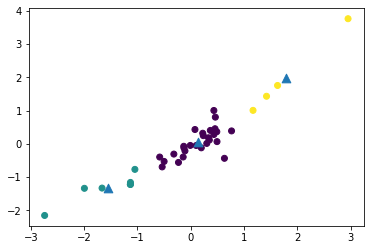

In [117]:
plt.scatter(brooklynCluster["count_2019"], brooklynCluster["count_2020"], c = model_example_1.labels_)

plt.scatter(model_example_1.cluster_centers_[:,0], model_example_1.cluster_centers_[:,1], s=75, marker = "^");

In [118]:
brooklynmap['clusters'] = model_example_1.labels_

In [119]:
brooklynmap.head()

,zipcode,geometry,count_2019,count_2020,percent_tot_2019,percent_tot_2020,percent_change,clusters
0,11221.0,"POLYGON Z ((-73.93822 40.68389 0.00000, -73.94...",9600,9446,4.076277,4.488115,-1.604167,2
1,11216.0,"POLYGON Z ((-73.94564 40.69203 0.00000, -73.94...",7219,6355,3.065276,3.019476,-11.968417,0
2,11233.0,"POLYGON Z ((-73.93822 40.68389 0.00000, -73.91...",7797,6409,3.310702,3.045133,-17.801719,0
3,11213.0,"POLYGON Z ((-73.93740 40.67973 0.00000, -73.92...",6363,6503,2.701808,3.089796,2.200220,0
4,11212.0,"POLYGON Z ((-73.90294 40.67084 0.00000, -73.90...",6966,6442,2.957849,3.060812,-7.522251,0


//anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:466: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


(-74.05121125029413, -73.8463739352844, 40.56111993449484, 40.74760389552892)

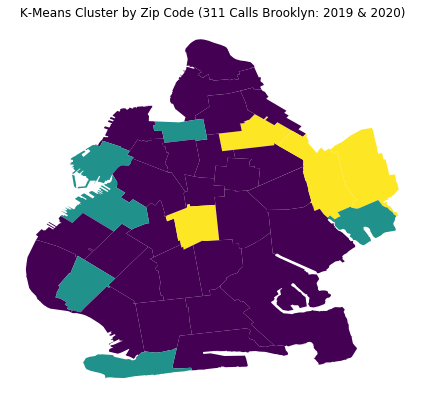

In [120]:
fig = plt.figure(figsize=(25,15))

variable = 'clusters'

ax = fig.add_subplot(131)
brooklynmap.plot(column=variable, axes=ax, legend=False)
ax.set_title("K-Means Cluster by Zip Code (311 Calls Brooklyn: 2019 & 2020)")
ax.axis('off')

## OLS Regression

In [121]:
brooklyn311Count = brooklynmap[['zipcode','count_2020']].copy()

brooklyn311Count.head()

,zipcode,count_2020
0,11221.0,9446
1,11216.0,6355
2,11233.0,6409
3,11213.0,6503
4,11212.0,6442


In [122]:
covid_cases = pd.read_csv('data-by-modzcta.csv')

covid_cases.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,387,1642.40,23563.03,23,97.61,10.25,3777
1,10002,Chinatown/Lower East Side,Manhattan,1096,1427.91,76755.41,158,205.85,14.30,7667
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,471,875.44,53801.62,33,61.34,7.93,5936
3,10004,Financial District,Manhattan,32,876.57,3650.61,1,27.39,8.21,390
4,10005,Financial District,Manhattan,65,774.17,8396.11,2,23.82,7.39,880


In [123]:
covid_bk = covid_cases[covid_cases['MODIFIED_ZCTA'].isin(brooklynzips)][['MODIFIED_ZCTA','COVID_CASE_COUNT']]

In [124]:
covid_bk.head()

,MODIFIED_ZCTA,COVID_CASE_COUNT
89,11201,742
90,11203,2141
91,11204,2070
92,11205,761
93,11206,1657


In [125]:
covid_bk.rename(columns={'MODIFIED_ZCTA':'zipcode'}, inplace=True)

In [126]:
covid_bk.head()

,zipcode,COVID_CASE_COUNT
89,11201,742
90,11203,2141
91,11204,2070
92,11205,761
93,11206,1657


In [127]:
covid_bk['zipcode'] = covid_bk['zipcode'].astype(str)

In [128]:
brooklyn311Count['zipcode'] = brooklyn311Count['zipcode'].astype(str).apply(lambda x: x.strip('.')[0:-2])

In [129]:
covid_ = brooklyn311Count.merge(covid_bk, on='zipcode')

In [130]:
covid_.head()

,zipcode,count_2020,COVID_CASE_COUNT
0,11221,9446,1371
1,11216,6355,765
2,11233,6409,1314
3,11213,6503,1450
4,11212,6442,1950


In [131]:
lm = smf.ols(formula='COVID_CASE_COUNT~count_2020', data = covid_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       COVID_CASE_COUNT   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     8.978
Date:                Sun, 19 Jul 2020   Prob (F-statistic):            0.00492
Time:                        12:12:17   Log-Likelihood:                -300.08
No. Observations:                  38   AIC:                             604.2
Df Residuals:                      36   BIC:                             607.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    675.0456    291.305      2.317      0.0

In [132]:
covid_.to_csv('brooklyn_311_covid.csv')